In [84]:
import pandas as pd 
import numpy as np 

In [85]:
import pymysql
config = {
    'host': '192.168.1.31',
    'port': 4000,
    'user': 'liyufan',
    'passwd': 'liyufan@2020',
    'charset':'utf8mb4',
    'cursorclass':pymysql.cursors.DictCursor
    }
conn = pymysql.connect(**config)

In [86]:
product_time = pd.read_sql("select ShelfAreaName,Qty,PickQty,PickEmpID,PickEmpName,EndPickingTime,StartPickingTime,DeliveryTime from xsyx_f6_picking.t_product_pick where OpAreaID = 101 and BatPickStatus = 3 and WID = 10139 and CreateTime between '2021-01-01 00:00:00' and '2021-01-31 23:59:59'" ,conn)

#### Select order after 23：00 & before 11:00

In [87]:
product_time_new = product_time.set_index("StartPickingTime").between_time("23:00", "11:00")
picking_time = product_time_new.reset_index(drop=False)

In [88]:
picking_time['duration'] = picking_time['EndPickingTime'] - picking_time['StartPickingTime']

In [98]:
#calculate work time by adding up the duration of pickingtime 
work_duration_list = []
for worker_id in picking_time['PickEmpID'].unique():
#for worker_id in [12441]:
    for date in picking_time.loc[picking_time.PickEmpID == worker_id]['DeliveryTime'].unique():
        product_worktime = picking_time.loc[(picking_time.PickEmpID == worker_id)&(picking_time.DeliveryTime == date)]['duration'].sum()
        picking_Qty = picking_time.loc[(picking_time.PickEmpID == worker_id)&(picking_time.DeliveryTime == date)]['PickQty'].sum()
        work_duration_list.append({'worker_id':worker_id,'date':date,'total_duration':product_worktime, "total_PickQty" : picking_Qty})
work_duration_df = pd.DataFrame(work_duration_list)

In [59]:
work_duration_df.shape

(2801, 4)

In [99]:
#calculate work
real_work_duration_list = []
for worker_id in picking_time['PickEmpID'].unique():
#for worker_id in [11758]:
    for date in picking_time.loc[picking_time.PickEmpID == worker_id]['DeliveryTime'].unique():
        real_product_worktime = picking_time.loc[(picking_time.DeliveryTime == date)&(picking_time.PickEmpID == worker_id)]['EndPickingTime'].max()-picking_time.loc[(picking_time.DeliveryTime == date)&(picking_time.PickEmpID == worker_id)]['StartPickingTime'].min()
       # print(picking_time.loc[picking_time.DeliveryTime == date]['EndPickingTime'].max())
        PickEmpName = picking_time.loc[(picking_time.PickEmpID == worker_id)]['PickEmpName'].to_list()[0]
        real_work_duration_list.append({'worker_id':worker_id,'PickEmpName':PickEmpName,'date':date,'real_total_duration':real_product_worktime})
        
test_real_work_duration_df = pd.DataFrame(real_work_duration_list)

In [100]:
new_df1 = pd.merge(work_duration_df, test_real_work_duration_df, on = ['worker_id', 'date'])

In [45]:
new_df1.head()

,worker_id,date,total_duration,total_PickQty,PickEmpName,real_total_duration
0,135427,2021-01-09,0 days 02:41:45,1284.0,石顺兴,0 days 04:48:55
1,135427,2021-01-01,0 days 01:43:56,826.0,石顺兴,0 days 04:03:23
2,135427,2021-01-08,0 days 01:54:20,1058.0,石顺兴,0 days 04:52:51
3,135427,2021-01-10,0 days 02:46:39,1385.0,石顺兴,0 days 05:54:01
4,135427,2021-01-02,0 days 01:52:46,946.0,石顺兴,0 days 04:42:36


In [101]:
new_df1[['total_duration', 'real_total_duration']] = new_df1[['total_duration', 'real_total_duration']]/np.timedelta64(1, 's')

In [102]:
new_df1 = new_df1[['worker_id', 'PickEmpName', 'date', 'total_PickQty', 'total_duration',
        'real_total_duration']]

In [53]:
new_df1.head()

,worker_id,PickEmpName,date,total_PickQty,total_duration,real_total_duration
0,135427,石顺兴,2021-01-09,1284.0,9705.0,17335.0
1,135427,石顺兴,2021-01-01,826.0,6236.0,14603.0
2,135427,石顺兴,2021-01-08,1058.0,6860.0,17571.0
3,135427,石顺兴,2021-01-10,1385.0,9999.0,21241.0
4,135427,石顺兴,2021-01-02,946.0,6766.0,16956.0


In [57]:
new_df1.sort_values(by=['worker_id', 'date'], ascending = True)

,worker_id,PickEmpName,date,total_PickQty,total_duration,real_total_duration
169,11758,杨祥,2021-01-01,1136.0,6659.0,11830.0
172,11758,杨祥,2021-01-02,1133.0,10134.0,16661.0
173,11758,杨祥,2021-01-03,922.0,9204.0,15347.0
177,11758,杨祥,2021-01-04,1991.0,10072.0,15920.0
178,11758,杨祥,2021-01-05,1698.0,8834.0,14105.0
...,...,...,...,...,...,...
2779,180065,冯正金,2021-01-29,1116.0,9232.0,19170.0
2783,180065,冯正金,2021-01-30,1324.0,11349.0,18653.0
2784,180065,冯正金,2021-01-31,1289.0,9904.0,19095.0
2781,180065,冯正金,2021-02-01,178.0,1635.0,1830.0


In [58]:
new_df1.to_csv('工作时长统计.csv')

In [106]:
picking_time.head()

,StartPickingTime,ShelfAreaName,Qty,PickQty,PickEmpID,PickEmpName,EndPickingTime,DeliveryTime,duration
0,2021-01-01 03:22:50,常规3组,49.0,49.0,141747,刘文,2021-01-01 03:32:19,2021-01-01,0 days 00:09:29
1,2021-01-01 02:00:39,生鲜10组,31.0,31.0,13898,胡坤,2021-01-01 02:05:20,2021-01-01,0 days 00:04:41
2,2021-01-01 02:07:22,生鲜6组,75.0,75.0,11786,徐小洁,2021-01-01 02:11:47,2021-01-01,0 days 00:04:25
3,2021-01-01 00:08:56,生鲜9组,17.0,17.0,13665,丁小顺,2021-01-01 00:10:41,2021-01-01,0 days 00:01:45
4,2021-01-01 01:53:46,常规3组,128.0,128.0,175892,雷雲鸿,2021-01-01 02:04:41,2021-01-01,0 days 00:10:55


In [268]:
resttime_count_list = []
for worker_id in picking_time['PickEmpID'].unique():
#for worker_id in [11758]:
    for date in picking_time.loc[picking_time.PickEmpID == worker_id]['DeliveryTime'].unique():
        resttime =picking_time.loc[(picking_time.DeliveryTime == date)&(picking_time.PickEmpID == worker_id)].sort_values(by= ['StartPickingTime', 'DeliveryTime'])
        resttime['shifted_EndPickingTime'] = resttime['EndPickingTime'].shift(1)
        resttime['difference'] = resttime['StartPickingTime']-resttime['shifted_EndPickingTime']
        resttime['difference_sec'] = resttime['difference'].dt.total_seconds()/60
        resttime_count = resttime[resttime['difference_sec'] > 5].shape[0] 
        PickEmpName = resttime['PickEmpName'].to_list()[0]
        total_PickQty = resttime['PickQty'].sum()
        resttime_count_list.append({'worker_id':worker_id,'PickEmpName':PickEmpName,'date':date,'resttime_count':resttime_count,'total_PickQty':total_PickQty})
resttime_count_df = pd.DataFrame(resttime_count_list)   

In [194]:
resttime_count_df.max() 

worker_id                      181971
PickEmpName                       龚浩民
date              2021-02-01 00:00:00
resttime_count                     10
total_PickQty                   21340
dtype: object

In [269]:
average_resttime_count_list = []
for date in resttime_count_df['date'].unique():
    total_resttime_day = resttime_count_df.loc[(resttime_count_df.date == date)]['resttime_count'].sum()
    total_worker = resttime_count_df.loc[(resttime_count_df.date == date)]['PickEmpName'].shape[0] 
    averate_resttime = total_resttime_day/total_worker
    average_resttime_count_list.append({'date':date,'average_resttime':averate_resttime})
    average_resttime_count_df = pd.DataFrame(average_resttime_count_list) 

In [270]:
average_resttime_count_df.sort_values('date', ascending = True)

,date,average_resttime
0,2021-01-01,4.047059
1,2021-01-02,4.857143
2,2021-01-03,4.888889
5,2021-01-04,4.845238
3,2021-01-05,5.322222
4,2021-01-07,5.336957
19,2021-01-08,5.882979
10,2021-01-09,6.032258
6,2021-01-10,6.402174
8,2021-01-11,5.055556


In [57]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Average Resttime')

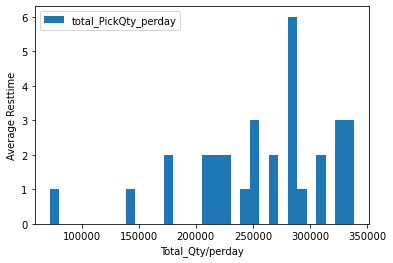

In [77]:
ax = average_resttime_count_df.plot( x='average_resttime', y='total_PickQty_perday', kind='hist',bins = 32)
ax.set_xlabel("Total_Qty/perday")
ax.set_ylabel("Average Resttime")

In [78]:
fig = ax.get_figure()
fig.savefig("output.png")

In [199]:
average_resttime_lt5_list=[]
for worker_id in picking_time['PickEmpID'].unique():
#for worker_id in [11758]:
    for date in picking_time.loc[picking_time.PickEmpID == worker_id]['DeliveryTime'].unique():
        resttime =picking_time.loc[(picking_time.DeliveryTime == date)&(picking_time.PickEmpID == worker_id)].sort_values(by= ['StartPickingTime', 'DeliveryTime'])
        resttime['shifted_EndPickingTime'] = resttime['EndPickingTime'].shift(1)
        resttime['difference'] = resttime['StartPickingTime']-resttime['shifted_EndPickingTime']
        resttime['difference_sec'] = resttime['difference'].dt.total_seconds()/60
        average_resttime_lt5_list.append(resttime['difference_sec'])
average_resttime_lt5_df = pd.concat(average_resttime_lt5_list) 

KeyError: ('difference_sec', 'PickEmpID')

In [189]:
average_resttime_lt5_df = average_resttime_lt5_df.to_frame('resttime_min')

In [216]:
resttime_sort = average_resttime_lt5_df[average_resttime_lt5_df['resttime_min']>=5].astype(int).value_counts()

In [ ]:
#When you are doing value_counts, it will return a series, 
#so I am adding .reset_index().values after value_counts, to make index also become the value 

In [251]:
resttime_sort = pd.DataFrame(average_resttime_lt5_df[(average_resttime_lt5_df['resttime_min']>=5) & (average_resttime_lt5_df['resttime_min']<=25)].astype(int).value_counts().reset_index().values, columns=["rest_time", "counts"])

In [252]:
resttime_sort_toplot = resttime_sort.loc[resttime_sort['counts'] != 1]

In [253]:
resttime_sort_toplot.sort_values(by = 'rest_time',ascending = False)

,rest_time,counts
20,25,2
19,24,141
18,23,148
16,22,163
17,21,157
15,20,203
14,19,210
13,18,232
11,17,276
12,16,244


In [249]:
%matplotlib inline 
import matplotlib.pyplot as plt

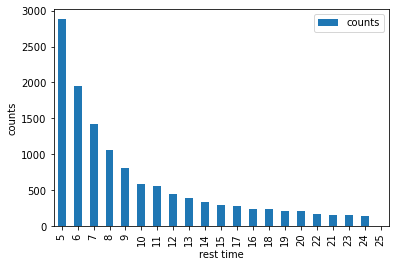

In [265]:
ax2 = resttime_sort_toplot.plot(x='rest_time', y='counts', kind='bar')
ax2.set_xlabel("rest time")
ax2.set_ylabel("counts")

In [267]:
fig = ax2.get_figure()
fig.savefig("resttime_count.png",facecolor='w', edgecolor='w')